In [1]:
import numpy as np
import gym
from gym import spaces
import math
import matplotlib.pyplot as plt

In [2]:
"""
Define the Roulette Environment Reward Mechanism
Define Epsilon Greedy Strategy
Define Polynomial Learning Rate
"""
# Define a Roulette environment class, inherited from gym.Env
class RouletteEnv(gym.Env):
    def __init__(self):
        super(RouletteEnv, self).__init__()  # Inherited gym.Env
        self.action_space = spaces.Discrete(171)  # Define a discrete action space with 171 possible actions
        self.observation_space = spaces.Discrete(1)  # Define an observation space with 1 possible state
        self.current_step = 0  # Initialize a counter for the current step

    def step(self, action):
        if action == 170:  # If the action is to stop playing
            return 0, 0, True, {}

        winning_number = np.random.choice(37)  # Choose a random winning number from 0 to 36
        reward = -1  # Assume player bets $1 each time and initialize the reward as -1

        # If player bets on a number and wins, they get a reward of 35
        if action < 36 and action == winning_number:
            reward = 35

        # If player bets on red or black and wins, they get a reward of 1
        elif action == 36 or action == 37:
            if (action == 36 and winning_number % 2 == 1) or (action == 37 and winning_number % 2 == 0):
                reward = 1

        # Bet on even or odd
        elif action == 38 or action == 39:
            if (action == 38 and winning_number % 2 == 0) or (action == 39 and winning_number % 2 == 1):
                reward = 1

        # Bet on low (1-18) or high (19-36)
        elif action == 40 or action == 41:
            if (action == 40 and 1 <= winning_number <= 18) or (action == 41 and 19 <= winning_number <= 36):
                reward = 1

        # Bet on first 12, second 12, or third 12
        elif action >= 42 and action <= 44:
            if (action == 42 and 1 <= winning_number <= 12) or \
                    (action == 43 and 13 <= winning_number <= 24) or \
                    (action == 44 and 25 <= winning_number <= 36):
                reward = 2

        # Bet on column
        elif action >= 45 and action <= 47:
            if (action == 45 and winning_number % 3 == 1) or \
                    (action == 46 and winning_number % 3 == 2) or \
                    (action == 47 and winning_number % 3 == 0):
                reward = 2

        # Bet on two adjacent numbers
        elif action >= 48 and action <= 82:
            if winning_number in [(action - 48), (action - 47)]:
                reward = 17

        # Bet on two numbers at the column intersection
        elif action >= 83 and action <= 94:
            columns = [(0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36), (1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34),
                       (2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35)]
            column_pairs = [(columns[0], columns[1]), (columns[1], columns[2])]
            for pair in column_pairs:
                if winning_number in pair[0] and winning_number in pair[1]:
                    reward = 17

        return 0, reward, False, {}

    def reset(self):
        # Reset the environment to its initial state
        self.current_step = 0
        return 0



# Define a function for selecting an action using epsilon-greedy strategy
def epsilon_greedy(Q, state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.choice(Q.shape[1])  # Randomly select an action
    else:
        action = np.argmax(Q[state])  # Select the action with the highest estimated reward
    return action

# Define a function for calculating a polynomial learning rate
def polynomial_learning_rate(base, exponent, t):
    t = max(t, 1)  # Ensure t is not zero
    return base / (t ** exponent)

def decay_epsilon(epsilon_start, epsilon_end, decay_rate, i_episode):
    return epsilon_end + (epsilon_start - epsilon_end) * math.exp(-decay_rate * i_episode)

In [3]:
"""
Define Q Learning Algorithm
"""
def Q_learning(env, num_episodes, base_learning_rate, learning_rate_exponent, epsilon_start, epsilon_end, decay_rate, gamma):
    Q_table = np.zeros([env.observation_space.n, env.action_space.n])
    n_table = np.zeros_like(Q_table)
    MaxQ_table = np.full([env.observation_space.n, env.action_space.n], 0)
    abs_errors = []
    avg_action_values = []
    for i_episode in range(1, num_episodes + 1):
        state = env.reset()
        done = False
        alpha = polynomial_learning_rate(base_learning_rate, learning_rate_exponent, i_episode)
        epsilon = decay_epsilon(epsilon_start, epsilon_end, decay_rate, i_episode)
        actions = []
        while not done:
            action = epsilon_greedy(Q_table, state, epsilon)
            n_table[state, action] += 1
            # alpha = 1 / n_table[state, action]
            actions.append(action)
            next_state, reward, done, info = env.step(action)
            old_value = Q_table[state][action]
            Q_table[state][action] = (1 - alpha) * old_value + alpha * (reward + gamma * np.max(Q_table[next_state]))
            state = next_state
        abs_errors.append(np.mean(np.abs(Q_table - MaxQ_table)))
        avg_action_values.append(np.mean(Q_table[state, :]))
    return Q_table, abs_errors, avg_action_values

In [4]:
"""
Define Double Q Learning Algorithm
"""
def double_Q_learning(env, num_episodes, base_learning_rate, learning_rate_exponent, epsilon_start, epsilon_end, decay_rate, gamma):
    Q1_table = np.zeros([env.observation_space.n, env.action_space.n])
    Q2_table = np.zeros([env.observation_space.n, env.action_space.n])
    n1_table = np.zeros_like(Q1_table)
    n2_table = np.zeros_like(Q2_table)
    MaxQ_table = np.full([env.observation_space.n, env.action_space.n], 0)
    abs_errors = []
    avg_action_values = []
    for i_episode in range(1, num_episodes + 1):
        state = env.reset()
        done = False
        alpha = polynomial_learning_rate(base_learning_rate, learning_rate_exponent, i_episode)
        epsilon = decay_epsilon(epsilon_start, epsilon_end, decay_rate, i_episode)
        actions = []
        while not done:
            action = epsilon_greedy(Q1_table + Q2_table, state, epsilon)
            actions.append(action)
            next_state, reward, done, info = env.step(action)
            if np.random.binomial(1, 0.5) == 1:
                n1_table[state, action] += 1
                # alpha = 1 / n1_table[state, action]
                best_next_action = np.argmax(Q1_table[next_state])
                Q1_table[state][action] = (1 - alpha) * Q1_table[state][action] + alpha * (reward + gamma * Q2_table[next_state][best_next_action])
            else:
                n2_table[state, action] += 1
                alpha = 1 / n2_table[state, action]
                best_next_action = np.argmax(Q2_table[next_state])
                Q2_table[state][action] = (1 - alpha) * Q2_table[state][action] + alpha * (reward + gamma * Q1_table[next_state][best_next_action])
            state = next_state
        abs_errors.append(np.mean(np.abs((Q1_table + Q2_table) / 2 - MaxQ_table)))
        avg_action_values.append(np.mean((Q1_table + Q2_table)[state, :] / 2))
    return Q1_table, Q2_table, abs_errors, avg_action_values

In [5]:
"""
Define Smoothed Q Learning Algorithm
"""
def smoothed_Q_learning(env, num_episodes, base_learning_rate, learning_rate_exponent, epsilon_start, epsilon_end, decay_rate, gamma, selection_method):
    Q_table = np.zeros([env.observation_space.n, env.action_space.n])
    n_table = np.zeros_like(Q_table)
    MaxQ_table = np.full([env.observation_space.n, env.action_space.n], 0)
    abs_errors = []
    avg_action_values = []

    def softmax(Q_state, beta):
        Q_normalized = (Q_state - np.mean(Q_state)) / (
                    np.std(Q_state) + 1e-10)  # Added epsilon to avoid division by zero
        exps = np.exp(beta * Q_normalized)
        probs = exps / np.sum(exps)
        probs = probs / np.sum(probs)  # Ensure probabilities sum to 1
        if np.isnan(probs).any():
            probs = np.ones_like(Q_state) / len(Q_state)
        return probs

    def clipped_softmax(Q_state, beta):
        Q_clipped = np.ones_like(Q_state) * (-np.inf)
        top_k_indices = np.argsort(Q_state)[-3:]
        Q_clipped[top_k_indices] = Q_state[top_k_indices] - np.max(Q_state)  # Subtract the maximum value
        exps = np.exp(beta * Q_clipped)
        return exps / np.sum(exps)

    def argmaxR(Q_state):
        max_value_indices = np.argwhere(Q_state == np.amax(Q_state)).flatten().tolist()
        return np.random.choice(max_value_indices)

    for i_episode in range(num_episodes):
        state = env.reset()
        done = False
        beta = 0.1 + 0.1 * (i_episode + 1)
        mu = np.exp(-0.02 * i_episode)
        actions = []
        epsilon = decay_epsilon(epsilon_start, epsilon_end, decay_rate, i_episode)
        alpha = polynomial_learning_rate(base_learning_rate, learning_rate_exponent, i_episode)

        while not done:
            if np.random.rand() > epsilon:
                action = argmaxR(Q_table[state])
            else:
                if selection_method == 'softmax':
                    action = np.random.choice(np.arange(env.action_space.n), p=softmax(Q_table[state], beta))
                elif selection_method == 'clipped_max':
                    A = len(Q_table[state])
                    action_distribution = np.full(A, mu / (A - 1))
                    action_distribution[argmaxR(Q_table[state])] = 1 - mu
                    action = np.random.choice(np.arange(env.action_space.n), p=action_distribution)
                elif selection_method == 'clipped_softmax':
                    action = np.random.choice(np.arange(env.action_space.n), p=clipped_softmax(Q_table[state], beta))
            actions.append(action)
            n_table[state, action] += 1
            # alpha = 1 / n_table[state, action]
            next_state, reward, done, _ = env.step(action)

            if selection_method == 'softmax':
                action_distribution = softmax(Q_table[next_state], beta)
            elif selection_method == 'clipped_max':
                A = len(Q_table[next_state])
                action_distribution = np.ones(A) * mu / (A - 1) if A != 1 else np.ones(A)
                as_ = argmaxR(Q_table[next_state])
                action_distribution[as_] = 1 - mu
            elif selection_method == 'clipped_softmax':
                action_distribution = clipped_softmax(Q_table[next_state], beta)

            expected_return = reward + gamma * np.sum(Q_table[next_state] * action_distribution)
            Q_table[state][action] = Q_table[state][action] + alpha * (expected_return - Q_table[state][action])
            state = next_state

        abs_errors.append(np.mean(np.abs(Q_table - MaxQ_table)))
        avg_action_values.append(np.mean(Q_table[state, :]))

    return Q_table, abs_errors, avg_action_values

In [25]:
"""
在考虑Roulette游戏环境和相应的奖励机制时，确定合适的先验均值（mu_prior）、先验方差（sigma_prior）、以及观测噪声（sigma_observation）对于设计有效的贝叶斯认知模型至关重要。这些参数反映了智能体对环境初步的认知和对未来观测的不确定性预期。以下是这些参数的评估方法：

先验均值（mu_prior）
先验均值代表智能体对于从环境中获取奖励的初始期望。在Roulette游戏中，考虑到多种下注方式和对应的奖励结构，合理的策略是设定一个较为保守的先验均值。考虑到大多数下注的期望值是负的（赌场优势），一个合理的先验均值可能接近于玩家下注的平均损失。例如，对于单数下注，胜率是1/37（考虑到0），奖励为35，期望收益是(1/37)35 + (36/37)(-1) ≈ -0.027。因此，一个反映整体游戏结构的先验均值可以是负数，如-0.027或类似，反映出在没有任何特定策略下的平均结果。

先验方差（sigma_prior）
先验方差反映了智能体对其奖励预期的初始不确定性。由于Roulette是一个具有高度随机性的游戏，且可能的奖励范围从-1到几十，一个较大的先验方差（例如1或更高）可能更为合适。这表示智能体对初始奖励预期的不确定性较大，准备根据接收到的奖励数据来调整其预期。

观测噪声（sigma_observation）
观测噪声表示在实际观测到的奖励值中存在的随机性或噪声水平。在Roulette游戏中，由于奖励的确定性完全依赖于随机选择的数字，观测噪声相对较小。然而，考虑到实际操作中可能存在的任何测量或估计误差，一个小的非零值（如0.1或0.01）可以提供足够的灵活性，以适应潜在的微小偏差。

综合考虑以上因素，在设置Roulette环境的贝叶斯认知模型时，可以选择如下参数：

mu_prior = -0.027 （或根据特定策略进行调整）
sigma_prior = 1 （反映对奖励预期的高度不确定性）
sigma_observation = 0.1 （反映较小的观测噪声）

"""

def update_bayesian_posterior(mu_prior, sigma_prior, rewards, sigma_observation=0.1):
    epsilon = 1e-10
    n = len(rewards)
    if n == 0:
        return mu_prior, sigma_prior
    reward_sum = np.sum(rewards)
    sigma_prior_squared = sigma_prior ** 2
    sigma_observation_squared = sigma_observation ** 2
    sigma_posterior_squared = 1.0 / ((1.0 / sigma_prior_squared) + (n / (sigma_observation_squared + epsilon)))
    mu_posterior = sigma_posterior_squared * ((mu_prior / sigma_prior_squared) + (reward_sum / (sigma_observation_squared + epsilon)))
    return mu_posterior, np.sqrt(sigma_posterior_squared)

def smoothed_Q_learning_cognitive_model(env, num_episodes, base_learning_rate, learning_rate_exponent, epsilon_start, epsilon_end, decay_rate, gamma):
    Q_table = np.zeros([env.observation_space.n, env.action_space.n])
    n_table = np.zeros_like(Q_table)
    MaxQ_table = np.full([env.observation_space.n, env.action_space.n], 0)
    abs_errors = []
    avg_action_values = []
    # Initialization parameter
    mu_prior = -0.027
    sigma_prior = 1.0
    sigma_observation = 0.1


    # def softmax(Q_state, beta):
    #     exps = np.exp(beta * (Q_state - np.max(Q_state)))
    #     return exps / np.sum(exps)

    def argmaxR(Q_state):
        max_value_indices = np.argwhere(Q_state == np.amax(Q_state)).flatten().tolist()
        return np.random.choice(max_value_indices)

    def clipped_softmax(Q_state, beta):
        Q_clipped = np.ones_like(Q_state) * (-np.inf)
        top_k_indices = np.argsort(Q_state)[-3:]
        Q_clipped[top_k_indices] = Q_state[top_k_indices] - np.max(Q_state)  # Subtract the maximum value
        exps = np.exp(beta * Q_clipped)
        return exps / np.sum(exps)


    for i_episode in range(num_episodes):
        state = env.reset()
        done = False
        beta = 0.1 + 0.1 * i_episode
        actions = []
        epsilon = decay_epsilon(epsilon_start, epsilon_end, decay_rate, i_episode)
        alpha = polynomial_learning_rate(base_learning_rate, learning_rate_exponent, i_episode + 1)
        episode_rewards = []

        while not done:
            if np.random.rand() > epsilon:
                action = argmaxR(Q_table[state])
            else:
                action_distribution = clipped_softmax(Q_table[state], beta)
                action = np.random.choice(np.arange(env.action_space.n), p=action_distribution)

            # action = epsilon_greedy(Q_table, state, epsilon)
            actions.append(action)
            n_table[state, action] += 1
            next_state, reward, done, _ = env.step(action)

            episode_rewards.append(reward)
            mu_prior, sigma_prior = update_bayesian_posterior(mu_prior, sigma_prior, episode_rewards, sigma_observation)
            adjusted_Q = Q_table + mu_prior
            action_distribution = clipped_softmax(adjusted_Q[next_state], beta)
            expected_return = reward + gamma * np.dot(action_distribution, adjusted_Q[next_state])
            Q_table[state][action] = Q_table[state][action] + alpha * (expected_return - Q_table[state][action])
            state = next_state

        abs_errors.append(np.mean(np.abs(Q_table - MaxQ_table)))
        avg_action_values.append(np.mean(Q_table[state, :]))

    return Q_table, abs_errors, avg_action_values

In [6]:
# Create the environment
env = RouletteEnv()

# Set the parameters for the experiment
num_episodes = 100000
base_learning_rate = 0.3
learning_rate_exponent = 0.5
epsilon_start = 1.0
epsilon_end = 0.1
decay_rate = 0.0001
gamma = 0.99
delta_start = 1.0

In [8]:
# Run the experiments
_, Q_learning_abs_errors, Q_learning_avg_action_values = Q_learning(env, num_episodes, base_learning_rate, learning_rate_exponent, epsilon_start, epsilon_end, decay_rate, gamma)
print("Q Learning Completed!")

Q Learning Completed!


In [9]:
_, _, double_Q_learning_abs_errors, double_Q_learning_avg_action_values = double_Q_learning(env, num_episodes, base_learning_rate, learning_rate_exponent, epsilon_start, epsilon_end, decay_rate, gamma)
print("Double Q Learning Completed!")

Double Q Learning Completed!


In [10]:
_, softmax_smoothed_abs_errors, softmax_smoothed_avg_action_values = smoothed_Q_learning(env, num_episodes, base_learning_rate, learning_rate_exponent, epsilon_start, epsilon_end, decay_rate, gamma, "softmax")
print("Softmax Smooth Q Learning Completed!")

/var/folders/ww/6n9cccss24g7s1y2w9tj4kvm0000gn/T/ipykernel_87870/1703111289.py:14: RuntimeWarning: overflow encountered in exp
  exps = np.exp(beta * Q_normalized)
/var/folders/ww/6n9cccss24g7s1y2w9tj4kvm0000gn/T/ipykernel_87870/1703111289.py:15: RuntimeWarning: invalid value encountered in divide
  probs = exps / np.sum(exps)
/Users/haydengu/anaconda3/envs/quant/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/ww/6n9cccss24g7s1y2w9tj4kvm0000gn/T/ipykernel_87870/1703111289.py:16: RuntimeWarning: divide by zero encountered in divide
  probs = probs / np.sum(probs)  # Ensure probabilities sum to 1
/var/folders/ww/6n9cccss24g7s1y2w9tj4kvm0000gn/T/ipykernel_87870/1703111289.py:16: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)  # Ensure probabilities sum to 1


Softmax Smooth Q Learning Completed!


In [11]:
_, clipped_max_smoothed_abs_errors, clipped_max_smoothed_avg_action_values = smoothed_Q_learning(env, num_episodes, base_learning_rate, learning_rate_exponent, epsilon_start, epsilon_end, decay_rate, gamma, "clipped_max")
print("Clipped max Smooth Q Learning Completed!")

Clipped max Smooth Q Learning Completed!


In [12]:
_, clipped_softmax_smoothed_abs_errors, clipped_softmax_smoothed_avg_action_values = smoothed_Q_learning(env, num_episodes, base_learning_rate, learning_rate_exponent, epsilon_start, epsilon_end, decay_rate, gamma, "clipped_softmax")
print("Clipped Softmax Smooth Q Learning Completed!")

Clipped Softmax Smooth Q Learning Completed!


In [26]:
_, bayes_smoothed_abs_errors, bayes_smoothed_avg_action_values = smoothed_Q_learning_cognitive_model(env, num_episodes, base_learning_rate, learning_rate_exponent, epsilon_start, epsilon_end, decay_rate, gamma)
print("Smooth Q Learning with Cognitive Model Completed!")

Smooth Q Learning with Cognitive Model Completed!


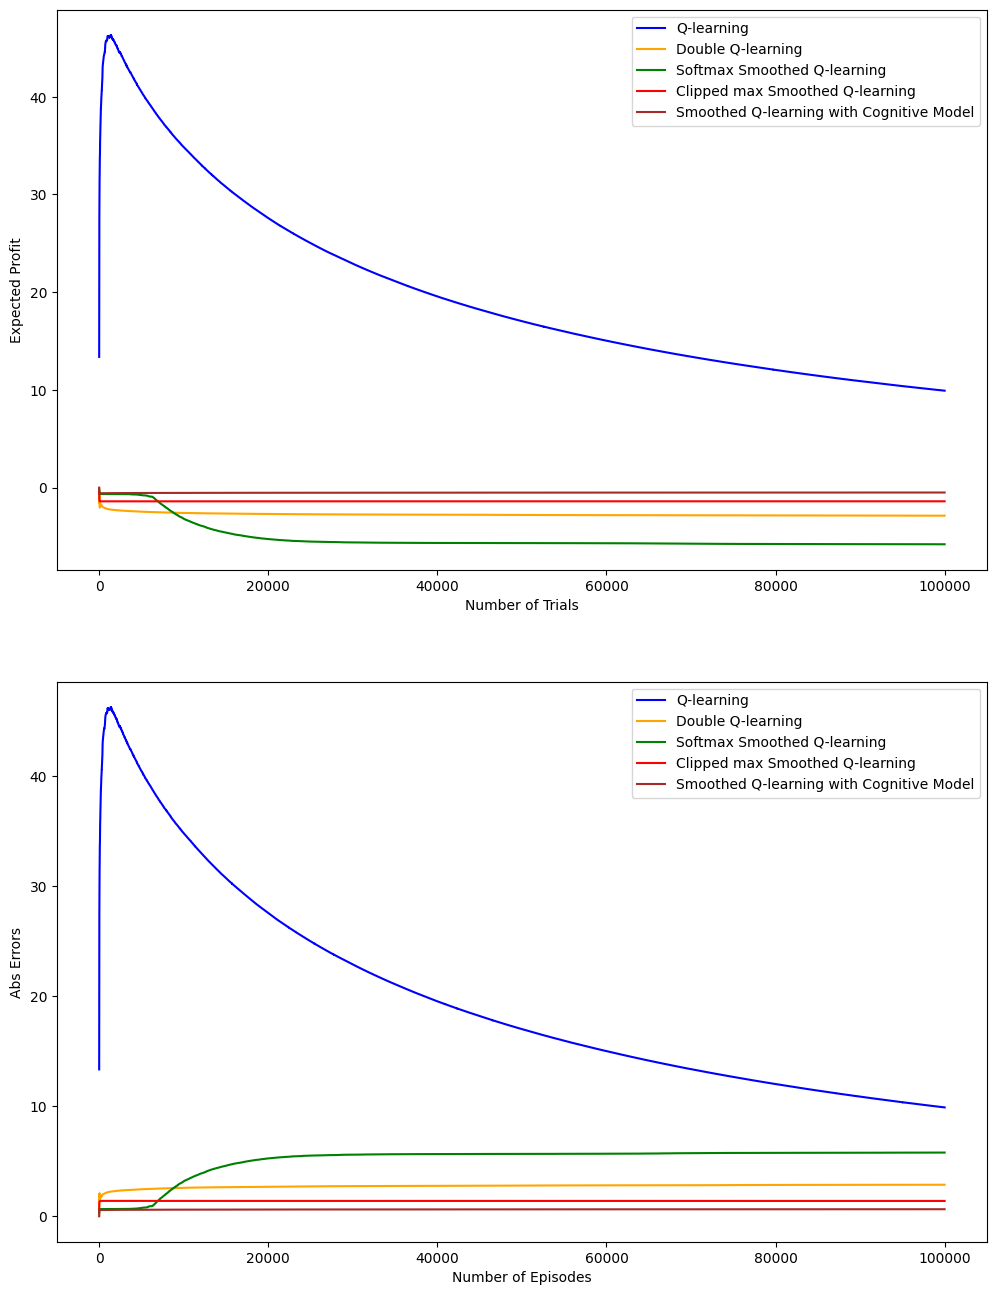

In [29]:
# Create subplots
fig, axs = plt.subplots(2, figsize=(12, 16))
# Plot the results for expected profit
axs[0].plot(range(num_episodes), Q_learning_avg_action_values, label='Q-learning', color='blue')
axs[0].plot(range(num_episodes), double_Q_learning_avg_action_values, label='Double Q-learning', color='orange')
axs[0].plot(range(num_episodes), softmax_smoothed_avg_action_values, label='Softmax Smoothed Q-learning', color='green')
axs[0].plot(range(num_episodes), clipped_max_smoothed_avg_action_values, label='Clipped max Smoothed Q-learning', color='red')
# axs[0].plot(range(num_episodes), clipped_softmax_smoothed_avg_action_values, label='Clipped Softmax Smoothed Q-learning', color='purple')
axs[0].plot(range(num_episodes), bayes_smoothed_avg_action_values, label='Smoothed Q-learning with Cognitive Model', color='brown')
axs[0].set_xlabel('Number of Trials')
axs[0].set_ylabel('Expected Profit')
axs[0].legend()

# Plot the results for abs_errors
axs[1].plot(range(num_episodes), Q_learning_abs_errors, label='Q-learning', color='blue')
axs[1].plot(range(num_episodes), double_Q_learning_abs_errors, label='Double Q-learning', color='orange')
axs[1].plot(range(num_episodes), softmax_smoothed_abs_errors, label='Softmax Smoothed Q-learning', color='green')
axs[1].plot(range(num_episodes), clipped_max_smoothed_abs_errors, label='Clipped max Smoothed Q-learning', color='red')
# axs[1].plot(range(num_episodes), clipped_softmax_smoothed_abs_errors, label='Clipped Softmax Smoothed Q-learning', color='purple')
axs[1].plot(range(num_episodes), bayes_smoothed_abs_errors, label='Smoothed Q-learning with Cognitive Model', color='brown')
axs[1].set_xlabel('Number of Episodes')
axs[1].set_ylabel('Abs Errors')
axs[1].legend()
plt.show()

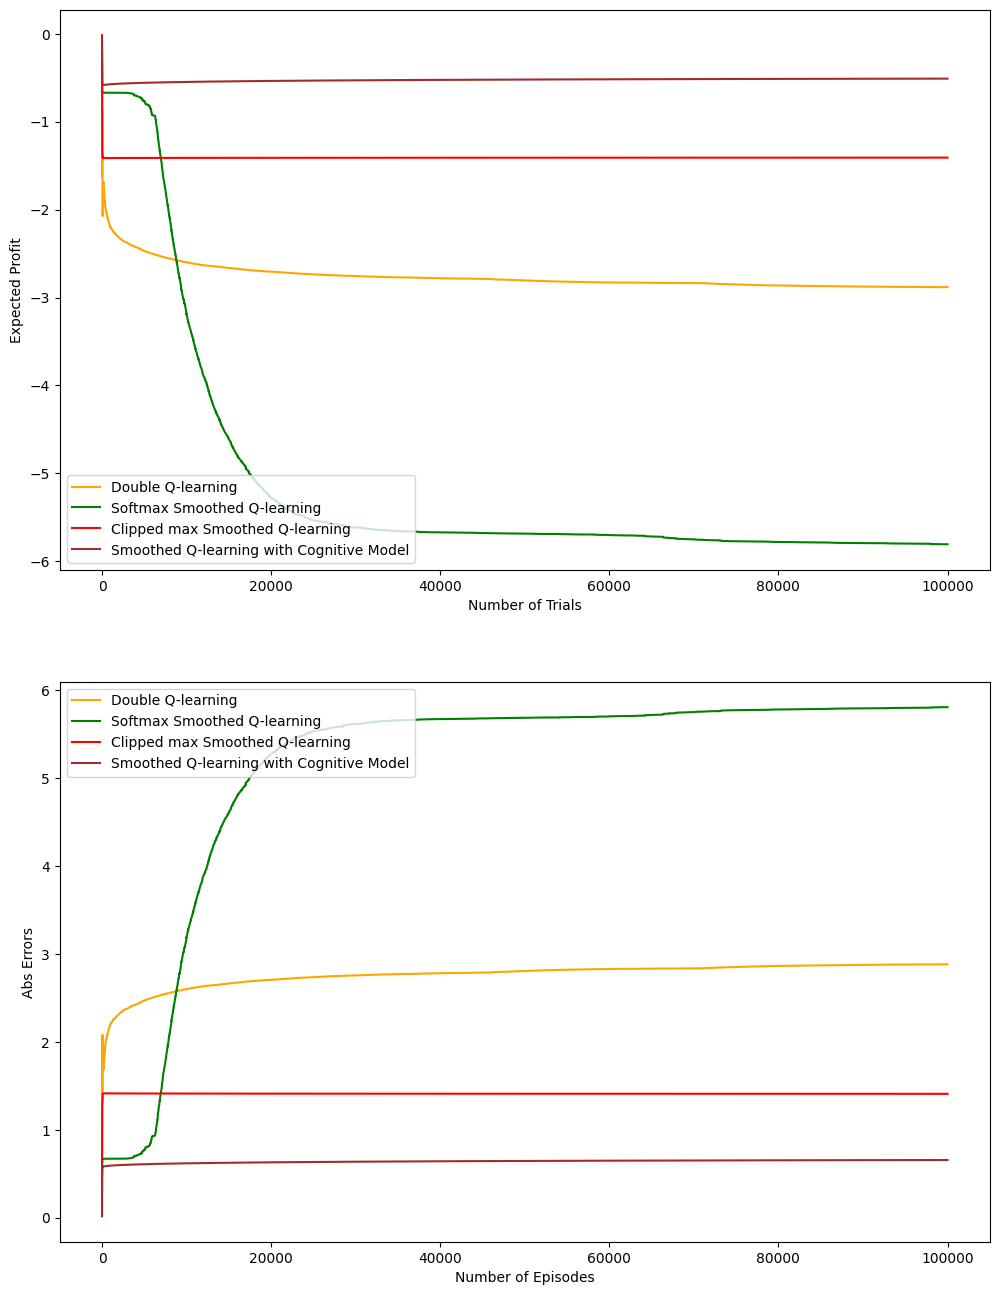

In [30]:
# Create subplots
fig, axs = plt.subplots(2, figsize=(12, 16))
# Plot the results for expected profit
# axs[0].plot(range(num_episodes), Q_learning_avg_action_values, label='Q-learning', color='blue')
axs[0].plot(range(num_episodes), double_Q_learning_avg_action_values, label='Double Q-learning', color='orange')
axs[0].plot(range(num_episodes), softmax_smoothed_avg_action_values, label='Softmax Smoothed Q-learning', color='green')
axs[0].plot(range(num_episodes), clipped_max_smoothed_avg_action_values, label='Clipped max Smoothed Q-learning', color='red')
# axs[0].plot(range(num_episodes), clipped_softmax_smoothed_avg_action_values, label='Clipped Softmax Smoothed Q-learning', color='purple')
axs[0].plot(range(num_episodes), bayes_smoothed_avg_action_values, label='Smoothed Q-learning with Cognitive Model', color='brown')
axs[0].set_xlabel('Number of Trials')
axs[0].set_ylabel('Expected Profit')
axs[0].legend()

# Plot the results for abs_errors
# axs[1].plot(range(num_episodes), Q_learning_abs_errors, label='Q-learning', color='blue')
axs[1].plot(range(num_episodes), double_Q_learning_abs_errors, label='Double Q-learning', color='orange')
axs[1].plot(range(num_episodes), softmax_smoothed_abs_errors, label='Softmax Smoothed Q-learning', color='green')
axs[1].plot(range(num_episodes), clipped_max_smoothed_abs_errors, label='Clipped max Smoothed Q-learning', color='red')
# axs[1].plot(range(num_episodes), clipped_softmax_smoothed_abs_errors, label='Clipped Softmax Smoothed Q-learning', color='purple')
axs[1].plot(range(num_episodes), bayes_smoothed_abs_errors, label='Smoothed Q-learning with Cognitive Model', color='brown')
axs[1].set_xlabel('Number of Episodes')
axs[1].set_ylabel('Abs Errors')
axs[1].legend()
plt.show()